In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import copy
import math
import time
import random
import webdataset as wds
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
import utils
from flat_models import *

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    %load_ext autoreload
    %autoreload 2
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

# create global variables from the config
print("\n__CONFIG__")
for attribute_name in config.keys():
    print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

data_type = torch.float16 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    import torch.multiprocessing as mp
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier()
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = flat_probe_Linear_normed
use_cls_token = False
use_contrastive_loss = True
contrastive_loss_weight = 0.025
hcp_flat_path = /weka/proj-fmri/shared/hcp_flat
batch_size = 32
num_workers = 10
num_epochs = 100
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
probe_num_samples_per_epoch = 50000
test_num_samples_per_epoch = 50000
grad_clip = 1.0
ckpt_saving = False
ckpt_interval = 20
print_interval = 20
resume_from_ckpt = True
wandb_log = True
tube_start_masking_ratio = 0.9
tube_end_masking_ratio = 0.9
decoder_mask_ratio = 0.9
norm_pix_loss = False
patch_size = [8, 8, 8]
frame_patch_size = 1
use_rope_emb = True
masking_strategy = None
encoder_model = vit_small
decoder_model = vit_small
img_size = [88, 104, 72]
num_frames = 1
is_s3 = False
test_urls = ['/weka/proj-fmri/shared/NSD_MNI_wds/000000.tar']
train_urls = ['/weka/proj-fmri/shared/NSD_MNI_wds/{000001..000736}.ta

# hcp_flat

In [2]:
from util.hcp_flat import load_hcp_flat_mask
from util.hcp_flat import create_hcp_flat
import util.visualize as vis

decoder_embed_dim = 512
num_frames = 16
if utils.is_interactive(): # Use less samples per epoch for debugging
    num_samples_per_epoch = 20000
    probe_num_samples_per_epoch = 2000
    test_num_samples_per_epoch = 2000
mask_ratio = .75
pred_t_dim = 8
t_patch_size = 2
cls_embed = True
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False

model = mae_vit_small_patch16_fmri(
    decoder_embed_dim=decoder_embed_dim,
    t_patch_size=t_patch_size,
    pred_t_dim=pred_t_dim,
    decoder_depth=4,
    cls_embed=cls_embed,
    norm_pix_loss=norm_pix_loss,
    no_qkv_bias=no_qkv_bias,
    sep_pos_embed=sep_pos_embed,
    trunc_init=trunc_init,
)
# state = torch.load("checkpoints/checkpoint-00099.pth", map_location="cpu")
# model.load_state_dict(state["model"])

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized


### Add downstream probe

In [3]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, h=256, num_classes=8):
        super(LinearProbe, self).__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
        
        # self.classifier = nn.Sequential(
        #     nn.LayerNorm(input_dim),
        #     nn.Linear(input_dim, num_classes)
        # )
        
        # self.classifier = nn.Sequential(
        #     nn.LayerNorm(input_dim),
        #     nn.GELU(),
        #     nn.Dropout(p=0.5),
        #     nn.Linear(input_dim, h),
        #     nn.LayerNorm(h),
        #     nn.GELU(),
        #     nn.Dropout(p=0.15),
        #     nn.Linear(h, h),
        #     nn.LayerNorm(h),
        #     nn.GELU(),
        #     nn.Dropout(p=0.15),
        #     nn.Linear(h, num_classes)
        # )
    def forward(self, x):
        x = nn.functional.normalize(x, dim=-1)
        x = self.classifier(x)
        return x

In [4]:
unique_subjects = torch.load("unique_subjects.pt")
print("len(unique_subjects)", len(unique_subjects))

unique_tasks = np.load("unique_tasks.npy")
print("len(unique_tasks)", len(unique_tasks))

len(unique_subjects) 979
len(unique_tasks) 14


## Create dataset and data loaders

In [5]:
num_batches = num_samples_per_epoch // (num_devices * batch_size)
probe_num_batches = probe_num_samples_per_epoch // (num_devices * batch_size)
test_num_batches = test_num_samples_per_epoch // (num_devices * batch_size)
print("num_batches", num_batches)
print("probe_num_batches", probe_num_batches)
print("test_num_batches", test_num_batches)

## Train ##
train_dataset = create_hcp_flat(root=hcp_flat_path, 
                    training=True, frames=num_frames)
train_dl = wds.WebLoader(
    train_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
train_dl = train_dl.with_epoch(num_batches)

## Probe ##
probe_dataset = create_hcp_flat(root=hcp_flat_path, 
                    training=True, frames=num_frames)
probe_dl = wds.WebLoader(
    probe_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
probe_dl = probe_dl.with_epoch(probe_num_batches)

## Test ##
test_dataset = create_hcp_flat(root=hcp_flat_path, 
                    training=False, frames=num_frames)
test_dl = wds.WebLoader(
    test_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
test_dl = test_dl.with_epoch(test_num_batches)

num_batches 625
probe_num_batches 62
test_num_batches 62


### Check data loaders work

Yielding 2 batches


  0%|          | 0/625 [00:00<?, ?it/s]

iter 0
subject_id [513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 513736, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 164636, 101915, 101915]
task_id ['GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'GAMBLING', 'RELATIONAL', 'RELATIONAL']
epochs 1
input_func torch.Size([32, 1, 16, 144, 320])
subject_id [189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 189652, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738, 352738]
len(su

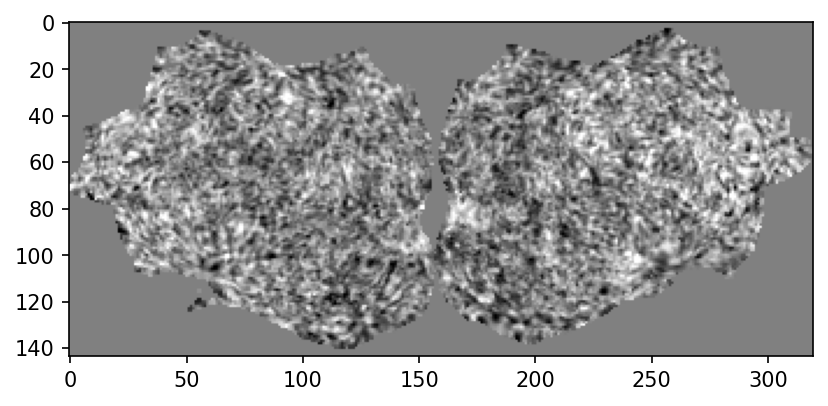

Execution time: 9.382829427719116 seconds


In [6]:
if utils.is_interactive():
    subject_list = []
    task_list = []
    
    start_time = time.time() 
    num_it = 2
    print(f"Yielding {num_it} batches")
    
    for i, batch in enumerate(tqdm(train_dl, total=num_batches)):
        input_func = batch[1]
        
        subject_id = batch[0]
        subject_id = [int(subject[4:].split("_")[0]) for subject in subject_id]
        subject_list.append(subject_id)
        
        task_id = batch[2]
        task_list.append(task_id)
        
        if i==0: print("iter",i)
        if i==0: print("subject_id", subject_id)
        if i==0: print("task_id", task_id)
        if i >= (num_it-1):
            break
    
    print("epochs", i)
    print("input_func", input_func.shape)
    print("subject_id", subject_id)
    print("len(subject_list)", len(subject_list))
    print("task_id", task_id)
    print("len(task_id)", len(subject_list))
    
    plt.imshow(input_func[0,0,0], cmap='gray')
    plt.show()
    
#     #### assuming you run the full epoch ####
#     unique_subjects = np.unique(np.array(subject_list).flatten())
#     torch.save(torch.Tensor(unique_subjects).long(), "unique_subjects.pt")
#     print("len(unique_subjects)", len(unique_subjects))
    
#     unique_tasks = np.unique(np.array(task_list).flatten())
#     unique_tasks = np.unique(np.array([''.join([char for char in s if not char.isdigit()]) for s in unique_tasks]))
#     np.save("unique_tasks.npy", unique_tasks)
#     print("len(unique_tasks)", len(unique_tasks))
#     ########

    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

# Set up optimizer and saving functions

In [7]:
print(f"\nChecking distributed setup on global_rank {global_rank}...")
from util.video_vit import Attention
if distributed:
    my_auto_wrap_policy = functools.partial(
        transformer_auto_wrap_policy, 
        transformer_layer_cls={
            Attention, # <--- Your Transformer layer class
        },
    )
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    model = FSDP(
        model,
        sharding_strategy=ShardingStrategy.HYBRID_SHARD,
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False,
        cpu_offload=None, #CPUOffload(offload_params=True)
        sync_module_states=True,
        limit_all_gathers=True, # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
    )
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [8]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.001 by effective batch size 32
lr = 0.000125

Done with model preparations!
param counts:
34,601,088 total
34,601,088 trainable


In [9]:
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)
def save_ckpt(model,tag="last"):
    if distributed: dist.barrier()
    model_states = model.state_dict()
    if global_rank == 0:
        os.makedirs(outdir,exist_ok=True)
        ckpt_path = outdir+f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")

outdir /weka/proj-fmri/paulscotti/fMRI-foundation-model/flat/checkpoints/flat_probe_j


# Start wandb (if enabled)

In [10]:
if utils.is_interactive():
    wandb_log = False
    ckpt_saving = False
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'fMRI-foundation-model'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "base_lr": base_lr,
      "lr": lr,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_urls": train_urls,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Start training

In [11]:
epoch = 0
lrs, train_losses, test_losses, probe_losses, probe_accs, test_probe_losses, test_probe_accs = [], [], [], [], [], [], []

In [13]:
grad_scaler = torch.cuda.amp.GradScaler(enabled=not (data_type==torch.float32))
mse = nn.MSELoss()
l1 = nn.L1Loss()
crossentropy = nn.CrossEntropyLoss()
if use_contrastive_loss:
    contrastive_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs)
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
for epoch in progress_bar:
    with torch.cuda.amp.autocast(dtype=data_type):
        model.train()
        for train_i, batch in enumerate(train_dl):
            optimizer.zero_grad()
            adjust_learning_rate(optimizer, train_i / num_batches + epoch)

            input_func = batch[1]
            # subject_id = batch[0]
            # subject_id = [int(subject[4:].split("_")[0]) for subject in subject_id]
            # subject_indices = torch.tensor([torch.where(unique_subjects == i)[0].item() for i in subject_id]).to(device)
            task_id = batch[2]
            task_id = np.array([''.join([char for char in s if not char.isdigit()]) for s in task_id])
            task_indices = torch.tensor([np.where(unique_tasks == i)[0].item() for i in task_id]).to(device)

            input_func = input_func.to(device, non_blocking=True)
            if len(input_func.shape) == 6:
                b, r, c, t, h, w = input_func.shape
                input_func = input_func.reshape(b * r, c, t, h, w)

            loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio)
            cls_latent = latent[:,0]

            grad_scaler.scale(loss).backward()
            grad_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            torch.cuda.synchronize()

            lrs.append(optimizer.param_groups[0]["lr"])
            train_losses.append(loss.item())

            if ((train_i%print_interval)==0 or (train_i==num_batches-1)) and train_i>0:
                print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
                if wandb_log: 
                    logs = {"train/loss": np.mean(train_losses[-print_interval:])}
                    # epoch_1000x as x-axis calibrates different curves when batch size changes
                    epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                    wandb.log(logs, step=epoch_1000x)
        model.eval()
        
        # Plot progress (first sample in batch)
        if utils.is_interactive() or wandb_log:
            with torch.no_grad():
                vis_out = vis.plot_mask_pred(
                    model, input_func, pred, mask, 
                    mean=0.5, std=0.2, 
                    norm_pix_loss=norm_pix_loss,
                )

                if wandb_log:
                    logs = {"train/mask_pred": wandb.Image(vis_out)}
                    epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                    wandb.log(logs, step=epoch_1000x)
                else:
                    display(vis_out)
                    
        ### Train linear probe from scratch ###
        linear_probe = LinearProbe(model.embed_dim,
                         h=model.embed_dim,
                         num_classes=len(unique_tasks)).to(device)
        probe_opt_grouped_parameters = [
            {'params': [p for n, p in linear_probe.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
            {'params': [p for n, p in linear_probe.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        ]
        probe_optimizer = torch.optim.AdamW(probe_opt_grouped_parameters, lr=3e-4, betas=(0.9, 0.95))
                    
        linear_probe.train()
        for probe_i, batch in enumerate(probe_dl):
            probe_optimizer.zero_grad()
            adjust_learning_rate(probe_optimizer, probe_i / probe_num_batches + epoch)

            input_func = batch[1]
            task_id = batch[2]
            task_id = np.array([''.join([char for char in s if not char.isdigit()]) for s in task_id])
            task_indices = torch.tensor([np.where(unique_tasks == i)[0].item() for i in task_id]).to(device)

            input_func = input_func.to(device, non_blocking=True)
            if len(input_func.shape) == 6:
                b, r, c, t, h, w = input_func.shape
                input_func = input_func.reshape(b * r, c, t, h, w)

            with torch.no_grad():
                _, pred, mask, latent = model(input_func, mask_ratio=mask_ratio)
                cls_latent = latent[:,0]
            
            task_pred = linear_probe(cls_latent)
            probe_loss = crossentropy(task_pred, task_indices)
            probe_acc = (torch.max(task_pred,1).indices == task_indices).sum() / len(task_indices)

            grad_scaler.scale(probe_loss).backward()
            grad_scaler.unscale_(probe_optimizer)
            torch.nn.utils.clip_grad_norm_(linear_probe.parameters(), max_norm=grad_clip)
            grad_scaler.step(probe_optimizer)
            grad_scaler.update()
            torch.cuda.synchronize()

            probe_losses.append(probe_loss.item())
            probe_accs.append(probe_acc.item())

        print(f"Ep. {epoch} | iter {probe_i} | probe_loss {np.mean(probe_losses[-probe_i:]):.3f} | probe_acc {np.mean(probe_accs[-probe_i:]):.3f} | lr {probe_optimizer.param_groups[0]['lr']}")
        if wandb_log: 
            logs = {"train/probe_loss": np.mean(probe_losses[-probe_i:]),
                    "train/probe_acc": np.mean(probe_accs[-probe_i:])}
            wandb.log(logs)
        linear_probe.eval()
        ######
        
        # Evaluate performance on held-out test dataset
        for test_i, batch in enumerate(test_dl):
            input_func = batch[1]
            task_id = batch[2]
            task_id = np.array([''.join([char for char in s if not char.isdigit()]) for s in task_id])
            task_indices = torch.tensor([np.where(unique_tasks == i)[0].item() for i in task_id]).to(device)

            input_func = input_func.to(device, non_blocking=True)
            if len(input_func.shape) == 6:
                b, r, c, t, h, w = input_func.shape
                input_func = input_func.reshape(b * r, c, t, h, w)

            loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio)
            cls_latent = latent[:,0]
            
            task_pred = linear_probe(cls_latent)
            probe_loss = crossentropy(task_pred, task_indices)
            probe_acc = (torch.max(task_pred,1).indices == task_indices).sum() / len(task_indices)

            test_losses.append(loss.item())
            test_probe_losses.append(probe_loss.item())
            test_probe_accs.append(probe_acc.item())

        print(f"Test | iter {test_i} | loss {np.mean(test_losses[-test_i:]):.3f} | probe_loss {np.mean(test_probe_losses[-test_i:]):.3f} | probe_acc {np.mean(test_probe_accs[-test_i:]):.3f}")
        if wandb_log: 
            logs = {"test/loss": np.mean(test_losses[-test_i:]),
                    "test/probe_loss": np.mean(test_probe_losses[-test_i:]),
                    "test/probe_acc": np.mean(test_probe_accs[-test_i:])}
            wandb.log(logs)
                
    # Plot progress (first sample in batch)
    if utils.is_interactive() or wandb_log:
        with torch.no_grad():
            vis_out = vis.plot_mask_pred(
                model, input_func, pred, mask, 
                mean=0.5, std=0.2, 
                norm_pix_loss=norm_pix_loss,
            )

            if wandb_log:
                logs = {"test/mask_pred": wandb.Image(vis_out)}
                wandb.log(logs)
            else:
                display(vis_out)

    # Save model checkpoint
    if (ckpt_saving) and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
        save_ckpt(model,"last")

    # wait for other GPUs to catch up if needed
    if distributed: dist.barrier()
        
if distributed: dist.destroy_process_group()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(train_losses)
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(probe_losses)
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(test_losses)
plt.show()
plt.figure(figsize=(8, 3))
plt.plot(test_probe_losses)
plt.show()